### Example Python Script to plot a single eShel spectral order



SIMPLE  =                    T                                                  BITPIX  =                  -32 / bits per data value                            NAXIS   =                    1 / Number of data axes                            NAXIS1  =                 9712 / Length of data axis 1                          SWCREATE= 'Demetra v5.1.2.0' / Software used to generate this file              EXPTIME =                    0 / [s] Total observation duration                 CDELT1  = 0.025303562393837326 / Wavelength pixel step (Angstrom)               CRVAL1  =   6469.3757406152299 / Wavelength pixel start (Angstrom)              BSCALE  =                    1 / linear factor in scaling equation              BZERO   =                    0 / zero point in scaling equation                 BSS_VHEL=                    0 / [km/s] Heliocentric velocity                   CRPIX1  =                    1 / Pixel start                                    CTYPE1  = 'Wavelength' / Axis 1 descript

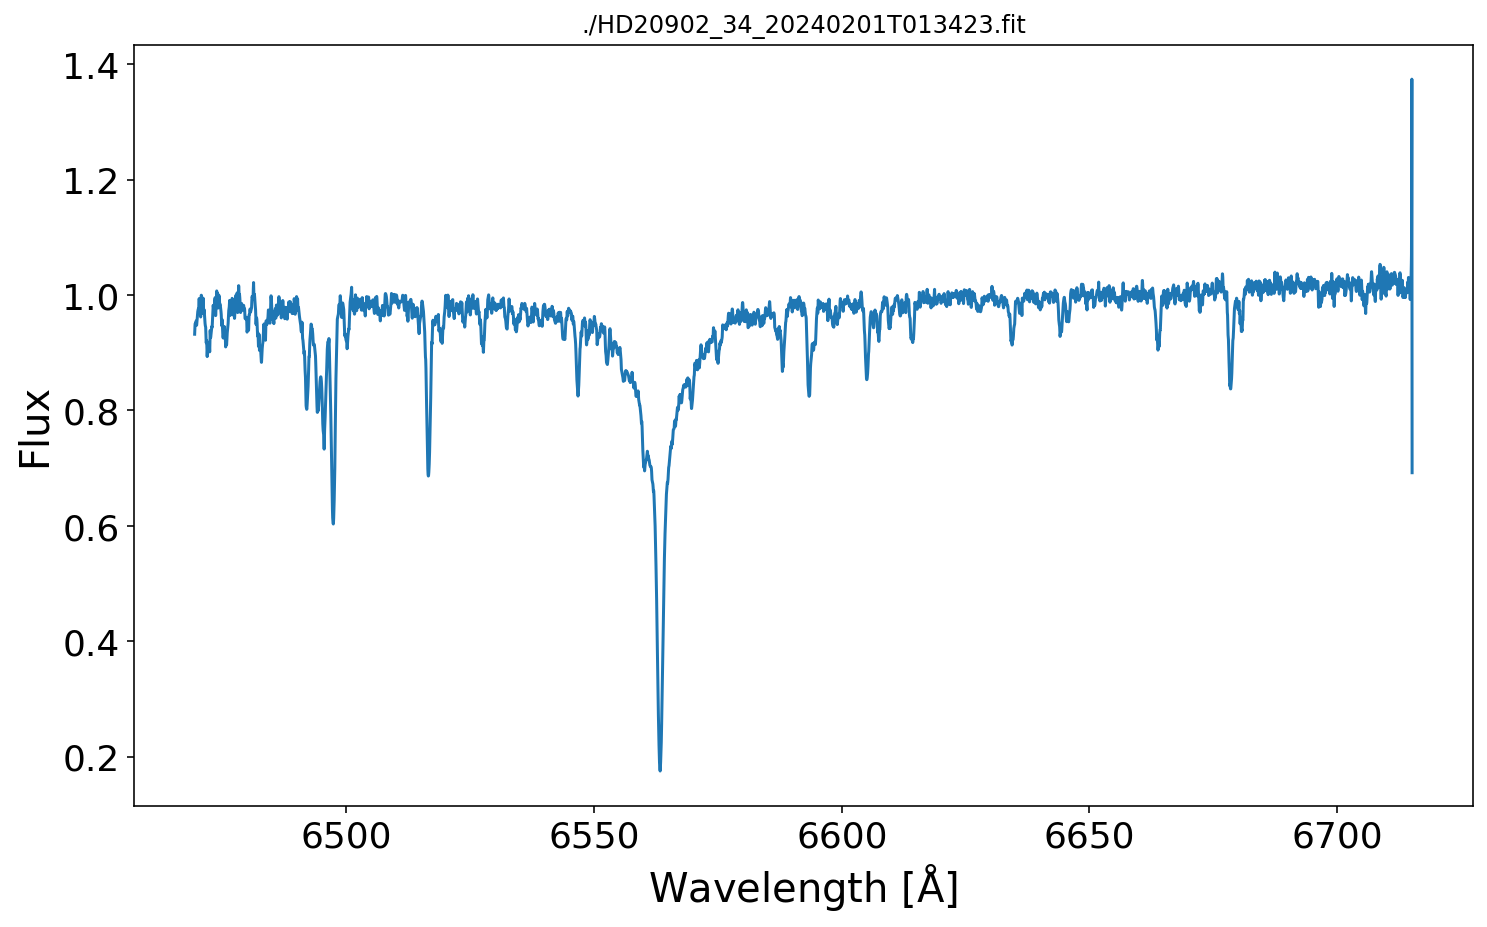

In [3]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
from astropy import constants as const
from specutils import Spectrum1D
from astropy.visualization import quantity_support
from specutils.fitting import fit_generic_continuum
from specutils.spectra import SpectralRegion 
from specutils.analysis import correlation
from astropy.nddata import StdDevUncertainty

#archive_path='./EpsilonAurigae_20240201015728_34.fit'
archive_path='./HD20902_34_20240201T013423.fit'

# y-axis (flux) values
fits_data = fits.getdata(archive_path, ext=0) #Save extension 0 from the fits file

#get the header info
hdul = fits.open(archive_path) #Open the fits file
hdr = hdul[0].header #Save the header from extension 0
print(hdr)
#-------------------------------------------------\
#Contruct the wavelength points for the x-axis    |
#-------------------------------------------------/
start_wave=hdr['CRVAL1'] #Save the first wavelength value from the header
print('start_wave = ',start_wave)
wave_step=hdr['CDELT1'] #Save the wavelength step value from the header
print('wave_step = ',wave_step)
num_wave_points=hdr['NAXIS1'] #Save the number of wavelength points from the header
print('num_wave_points = ',num_wave_points)
end_wave=start_wave+wave_step*num_wave_points #Calculate the final wavelength point
print('end_wave = ',end_wave)
#build wavelength array
wavelengths=np.linspace(start_wave,end_wave,num_wave_points) #Make an array for the wavelength values

#-------------------------------------------------\
#Normalize all the flux for the model and archive |
#-------------------------------------------------/
#archive_wave_chunk = np.logical_and(wavelengths >= 4000, wavelengths <= 4300)
#fits_data = fits_data[archive_wave_chunk]
#wavelengths=wavelengths[archive_wave_chunk]
#fits_data = fits_data/(np.mean(fits_data[archive_wave_chunk])) #Temporary method of normalizing the spectra

fig, ax=plt.subplots()
ax.set_xlabel('Wavelength [$\mathrm{\AA}$]',fontsize=20)
ax.set_ylabel('Flux',fontsize=20)
ax.set_title(archive_path)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.plot(wavelengths,fits_data)



### Normalize the spectrum to unity



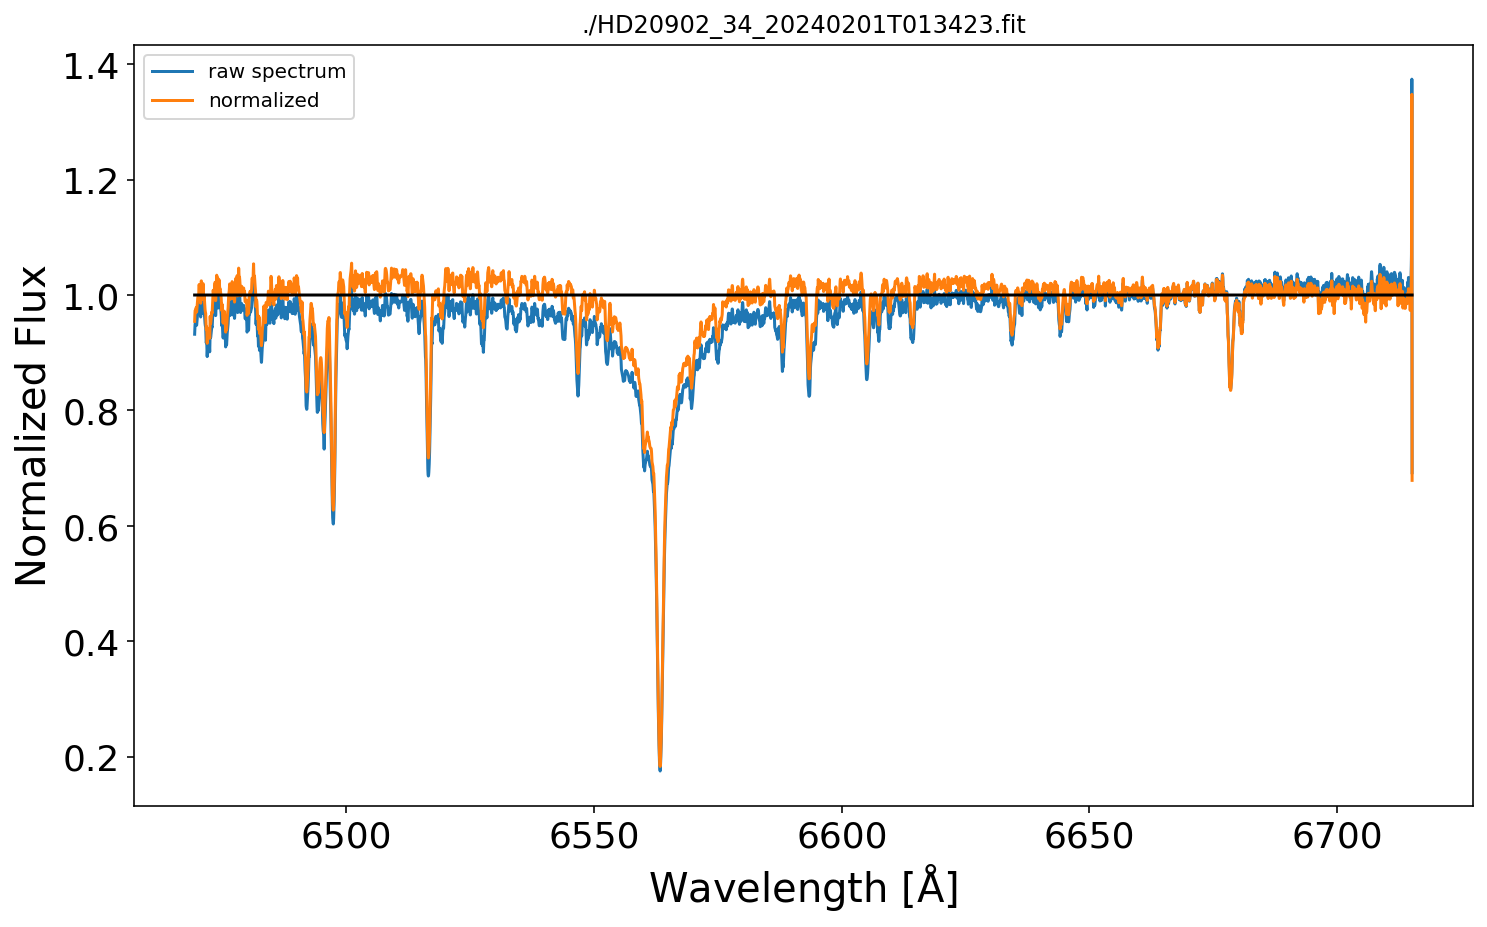

In [4]:
#quantity_support() 
#### put model is into 1D spec format with units!
fluxunit = u.erg / (u.cm ** 2 * u.second *u.AA)
wave_units=wavelengths*u.AA
flux_units=fits_data*fluxunit

#spectral region (sr) to avoid when fitting the continuum
sr = SpectralRegion(6480*u.AA, 6505*u.AA)+SpectralRegion(6515*u.AA,6530*u.AA)+SpectralRegion(6555*u.AA,6575*u.AA)

#create a specutils object
spec1d = Spectrum1D(spectral_axis=wave_units, flux=flux_units)
#divide the spectrum by a fit to the continuum
cont_norm_spec=spec1d / fit_generic_continuum(spec1d,median_window=5,exclude_regions=sr)(spec1d.spectral_axis) 

fig, ax=plt.subplots()
ax.set_xlabel('Wavelength [$\mathrm{\AA}$]',fontsize=20)
ax.set_ylabel('Normalized Flux',fontsize=20)
ax.set_title(archive_path)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.plot(wavelengths,fits_data,label='raw spectrum')
ax.plot(cont_norm_spec.spectral_axis, cont_norm_spec.flux,label='normalized')
ax.legend()
ones=np.ones(np.size(wavelengths))
ax.plot(wavelengths,ones,color='black')




#### Velocity corrections [https://astropy\-cjhang.readthedocs.io/en/latest/coordinates/velocities.html\#radial\-velocity\-corrections](https://astropy-cjhang.readthedocs.io/en/latest/coordinates/velocities.html#radial-velocity-corrections)



barycorr = -24.35044051250921 km / s
heliocorr =  -24.349696533922934 km / s


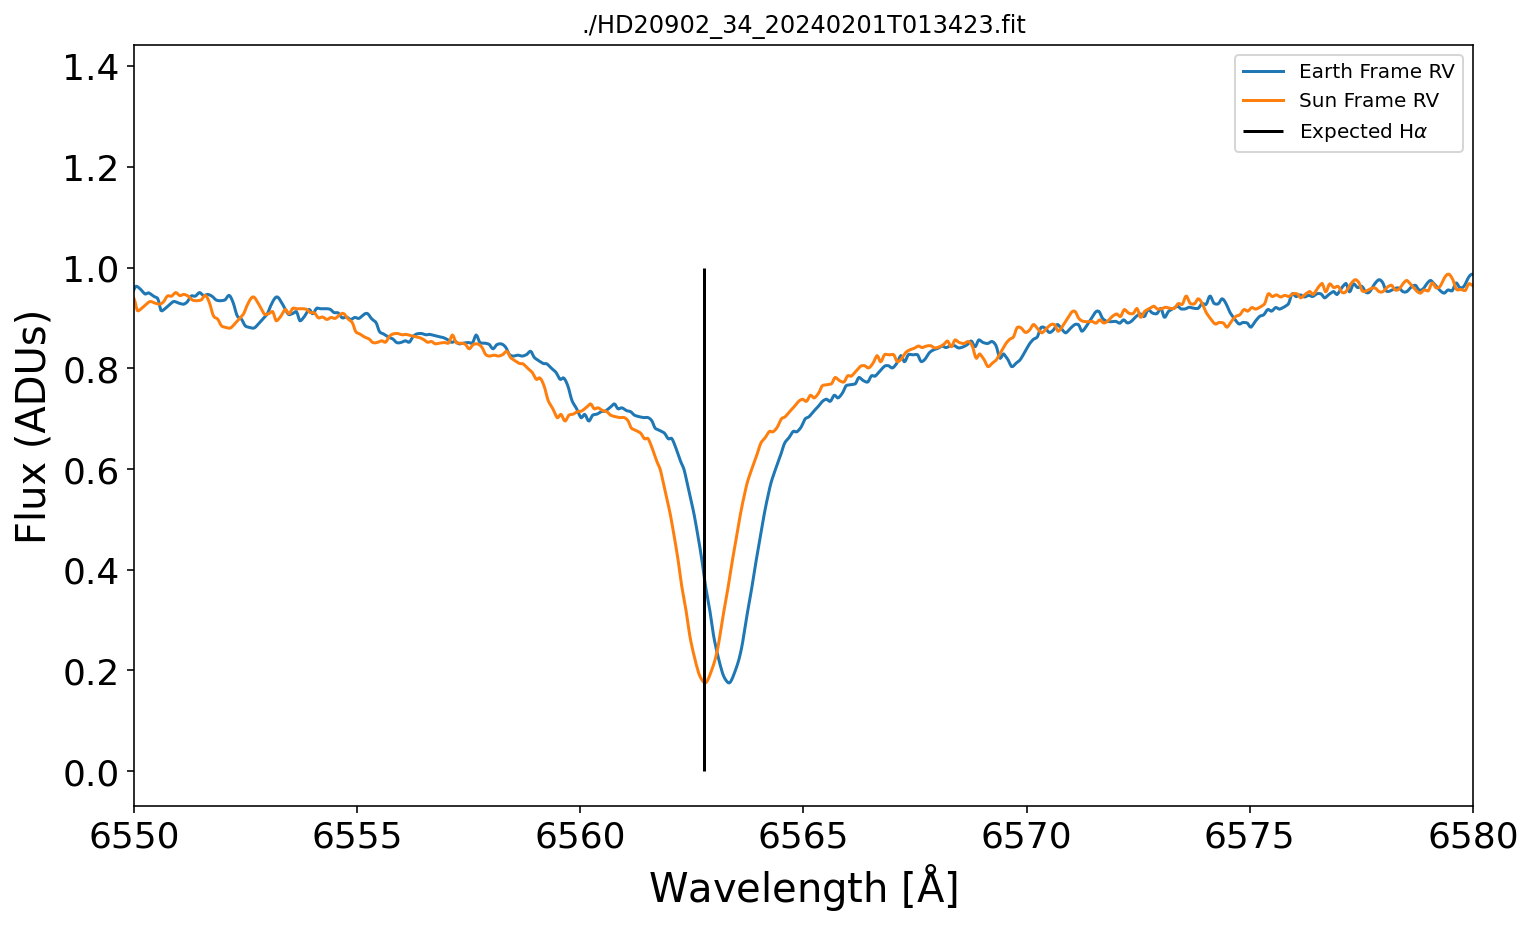

In [5]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
erau = EarthLocation.from_geodetic(lat=29.188183*u.deg, lon=-81.048313*u.deg, height=38*u.m)
#epsilon Aur  simbad R.A. and Dec for J2000 = 075.4922265361500 +43.8233103098100
#sc = SkyCoord(ra=075.4922265361500*u.deg, dec=43.8233103098100*u.deg,equinox='J2000')
#HD20902 simbad R.A. Dec for J000 051.0807087183 +49.8611792931
sc = SkyCoord(ra=051.0807087183*u.deg, dec=49.8611792931*u.deg,equinox='J2000')
barycorr = sc.radial_velocity_correction(obstime=Time('2024-2-1'), location=erau)  
print('barycorr =',barycorr.to(u.km/u.s))
heliocorr = sc.radial_velocity_correction('heliocentric', obstime=Time('2024-2-1'), location=erau)  
print('heliocorr = ',heliocorr.to(u.km/u.s))
to_helio=heliocorr.to(u.km/u.s)

wave_rvcorr = (to_helio/const.c)*wavelengths + wavelengths

fig, ax=plt.subplots()
ax.set_xlabel('Wavelength [$\mathrm{\AA}$]',fontsize=20)
ax.set_ylabel('Flux (ADUs)',fontsize=20)
ax.set_title(archive_path)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.plot(wavelengths,fits_data,label='Earth Frame RV')
ax.plot(wave_rvcorr,fits_data,label='Sun Frame RV')
ax.set_xlim([6550,6580])

RV_HD20902 = -2.158*u.km/u.s #from simbad
halpha_air=6562.81*u.AA #rest frame H-alpha in air
#expected observed H-alpha wavelength for HD 20902 in the heliocentric frame
halpha_obs = halpha_air + (RV_HD20902/const.c)*halpha_air
ax.vlines(halpha_obs.value,0,1,color='black',label=r'Expected H$\alpha$')
ax.legend()

### Cross correlation example \($\alpha$ Tau vs. HD 20902\)



/usr/local/lib/python3.10/dist-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Relative velocity shift:  57.6154 km / s


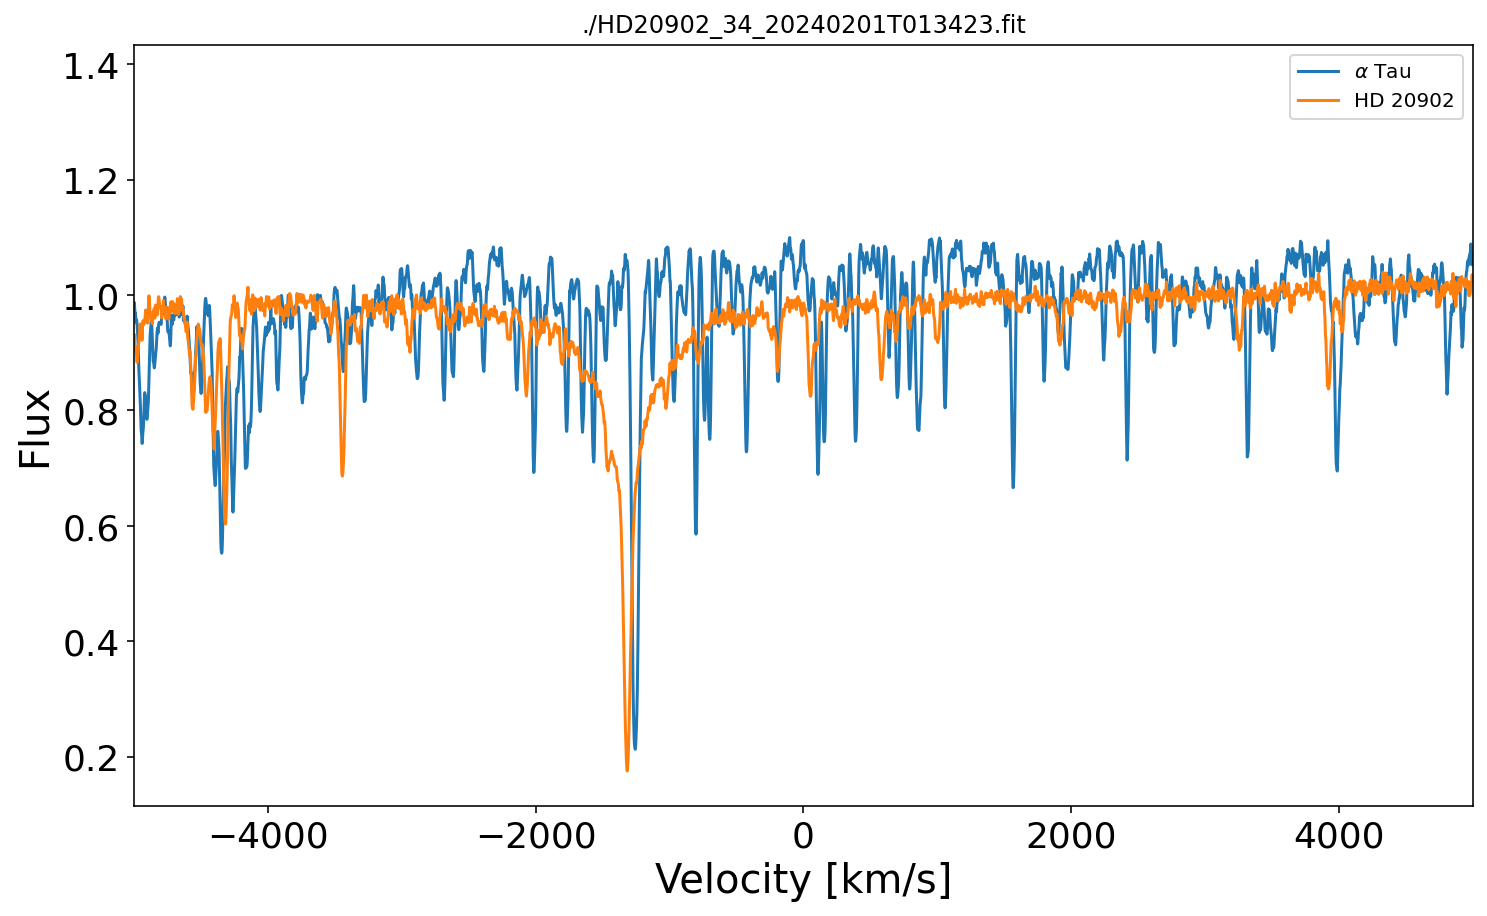

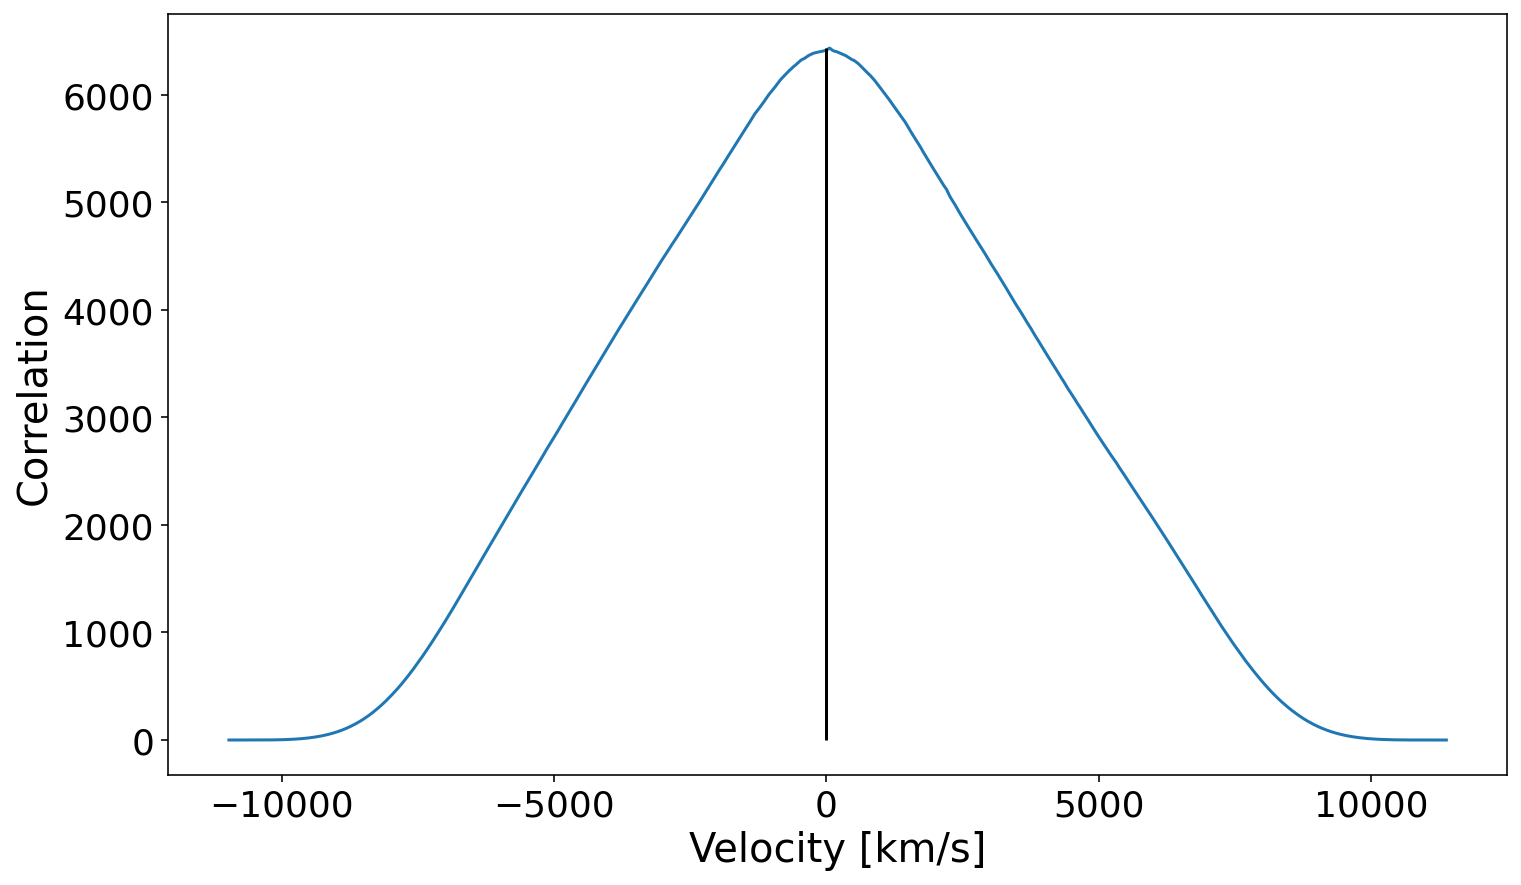

In [6]:
def get_wave_flux(path):
    import numpy as np
    from astropy.io import fits
    import matplotlib.pyplot as plt
    import pandas as pd
    from astropy import units as u
    from astropy import constants as const
    from specutils import Spectrum1D
    from astropy.visualization import quantity_support
    from specutils.fitting import fit_generic_continuum
    from specutils.spectra import SpectralRegion 
    from specutils.analysis import correlation
    from astropy.nddata import StdDevUncertainty

    flux = fits.getdata(path, ext=0) #Save extension 0 from the fits file
    hdul = fits.open(path) #Open the fiHD20902.listts file
    hdr = hdul[0].header #Save the header from extension 0
    #print(hdr)
#-------------------------------------------------\
#Contruct the wavelength points for the x-axis    |
#-------------------------------------------------/
    start_wave=hdr['CRVAL1'] #Save the first wavelength value from the header
    wave_step=hdr['CDELT1'] #Save the wavelength step value from the header
    num_wave_points=hdr['NAXIS1'] #Save the number of wavelength points from the header
    end_wave=start_wave+wave_step*num_wave_points #Calculate the final wavelength point
    wave=np.linspace(start_wave,end_wave,num_wave_points) #Make an array for the wavelength values
    return wave,flux
    
def get_spec1d(wave,flux,rest_value):
    import numpy as np
    from astropy.io import fits
    import matplotlib.pyplot as plt
    import pandas as pd
    from astropy import units as u
    from astropy import constants as const
    from specutils import Spectrum1D
    from astropy.visualization import quantity_support
    from specutils.fitting import fit_generic_continuum
    from specutils.spectra import SpectralRegion 
    from specutils.analysis import correlation
    from astropy.nddata import StdDevUncertainty

    quantity_support() 
    fluxunit = u.erg / (u.cm ** 2 * u.second *u.AA)
    uncertainty = StdDevUncertainty(0.01*np.ones(np.size(wave))*fluxunit)
    wave_units=wave*u.AA
    flux_units=flux*fluxunit
    spec1d = Spectrum1D(spectral_axis=wave_units, flux=flux_units, uncertainty=uncertainty,
        velocity_convention='optical',     rest_value=rest_value)
    return spec1d

def get_vhelio(wave,skycoords,obs_time):
    from astropy.time import Time
    from astropy.coordinates import SkyCoord, EarthLocation
    erau = EarthLocation.from_geodetic(lat=29.188183*u.deg, lon=-81.048313*u.deg, height=38*u.m)
    heliocorr = sc.radial_velocity_correction('heliocentric', obstime=Time(obs_time), location=erau)  
    to_helio=heliocorr.to(u.km/u.s)
    wave_vhelio = (to_helio/const.c)*wave + wave
    return wave_vhelio

def get_vel_diff(spec1,spec2):
    import numpy as np
    from astropy.io import fits
    import matplotlib.pyplot as plt
    import pandas as pd
    from astropy import units as u
    from astropy import constants as const
    from specutils import Spectrum1D
    from astropy.visualization import quantity_support
    from specutils.fitting import fit_generic_continuum
    from specutils.spectra import SpectralRegion 
    from specutils.analysis import correlation
    from astropy.nddata import StdDevUncertainty


    corr, lag = correlation.template_correlate(spec1,spec2)
    max = np.where(corr == np.max(corr))
    return lag[max[0]], corr, lag

def plot_spec_vel(spec1,spec2,label1,label2):
    fig, ax=plt.subplots()
    ax.set_xlabel('Velocity [km/s]',fontsize=20)
    ax.set_ylabel('Flux',fontsize=20)

    ax.set_title(archive_path)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.plot(spec1.velocity, spec1.flux,label=label1)
    ax.plot(spec2.velocity, spec2.flux,label=label2)
    ax.set_xlim([-5000,5000])
    ax.legend()

def plot_corr_lag(corr,lag):
    fig, ax=plt.subplots()
    ax.set_xlabel('Velocity [km/s]',fontsize=20)
    ax.set_ylabel('Correlation',fontsize=20)

    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.plot(lag, corr)
    ax.vlines(0,0,np.max(corr),color='black')
#    ax.set_xlim([-1000,1000])
#    ax.legend()
    
    
#archive_path1='./EpsilonAurigae_20240201015728_35.fit'
#wave1,flux1=get_wave_flux(archive_path1)
#sc1 = SkyCoord(ra=075.4922265361500*u.deg, dec=43.8233103098100*u.deg,equinox='J2000')
#wave1_vhelio=get_vhelio(wave1,sc1,'2024-2-1')
#spec1d_1=get_spec1d(wave1_vhelio,flux1)

archive_path1='./Spectrographtraining_34_20240201T001432.fit' #aldebaran RV=54.47
wave1,flux1=get_wave_flux(archive_path1)
sc1 = SkyCoord(ra=68.98016279*u.deg, dec=16.50930235*u.deg,equinox='J2000')
wave1_vhelio=get_vhelio(wave1,sc1,'2024-2-1')
spec1d_1=get_spec1d(wave1_vhelio,flux1,np.mean(wave1_vhelio)*u.AA)

archive_path2='./HD20902_34_20240201T013423.fit' #HD20902 RV=-2.158
wave2,flux2=get_wave_flux(archive_path2)
sc2 = SkyCoord(ra=51.0807087183*u.deg, dec=49.8611792931*u.deg,equinox='J2000')
wave2_vhelio=get_vhelio(wave2,sc2,'2024-2-1')
spec1d_2=get_spec1d(wave2_vhelio,flux2,np.mean(wave1_vhelio)*u.AA)

vel,corr,lag=get_vel_diff(spec1d_1,spec1d_2)
print("Relative velocity shift: ",'{:g}'.format(vel[0]))

plot_spec_vel(spec1d_1,spec1d_2,r'$\alpha$ Tau','HD 20902')
plot_corr_lag(corr,lag)

### Cross correlate all orders from 31 to 49



In [7]:
list_path='./HD20902_alftau.list'
list = pd.read_csv(list_path, delimiter = "\s+", header=None)
list.columns=['HD20902','alftau']

vel_save=[]
count=0
for i in range(0,len(list.alftau)):
    if ((i != 0) and (i != 1) and (i != 2) and (i != 9) and (i !=11) and (i != 12) and (i != 13) and (i !=14) and (i !=15) and (i !=16)):
        archive_path1=list.iloc[i,1]
        wave1,flux1=get_wave_flux(archive_path1)
        sc1 = SkyCoord(ra=68.98016279*u.deg, dec=16.50930235*u.deg,equinox='J2000')
        wave1_vhelio=get_vhelio(wave1,sc1,'2024-2-1')
        spec1d_1=get_spec1d(wave1_vhelio,flux1,np.mean(wave1_vhelio)*u.AA)

        archive_path2=list.iloc[i,0]
        wave2,flux2=get_wave_flux(archive_path2)
        sc2 = SkyCoord(ra=51.0807087183*u.deg, dec=49.8611792931*u.deg,equinox='J2000')
        wave2_vhelio=get_vhelio(wave2,sc2,'2024-2-1')
        spec1d_2=get_spec1d(wave2_vhelio,flux2,np.mean(wave1_vhelio)*u.AA)
        vel,corr,lag=get_vel_diff(spec1d_1,spec1d_2)
        vel_save.append(vel)
        count=count+1
print("Average of ",count," orders:")
print("Mean velocity difference:",'{:g}'.format(np.mean(vel_save)*u.km/u.s))
print("Error in the mean:",'{:g}'.format((np.std(vel_save)/np.sqrt(count))*u.km/u.s))
print("Expected veloicty difference:",'{:g}'.format((54.47-(-2.158))*u.km/u.s))


/usr/local/lib/python3.10/dist-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Average of  9  orders:
Mean velocity difference: 56.7259 km / s
Error in the mean: 1.25457 km / s
Expected veloicty difference: 56.628 km / s
